In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import rankdata
import math
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [3]:
defender = pd.read_csv("defender_bio_data.csv")
shooter = pd.read_csv("shooter_bio_data.csv")

defender_name = defender['full_name']
del defender['full_name']
del defender['bio_url']
del defender['height']
del defender['birth_year']
del defender['weight']

shooter_name = shooter['full_name']
del shooter['full_name']
del shooter['bio_url']
del shooter['height']
del shooter['birth_year']
del shooter['weight']

defender = defender.replace(to_replace='x', value=np.nan)
shooter = shooter.replace(to_replace='x', value=np.nan)

imp = preprocessing.Imputer(missing_values='NaN', strategy='mean')
defender = pd.DataFrame(imp.fit_transform(defender),columns=defender.columns) #use mean imputation on missing data
shooter  = pd.DataFrame(imp.fit_transform(shooter),columns=shooter.columns)

defender['full_name'] = defender_name
shooter['full_name']  = shooter_name 

In [4]:
raw = pd.read_csv("shot_logs.csv")
del raw['SHOT_RESULT'] # all these variables are repetitive 
del raw['CLOSEST_DEFENDER_PLAYER_ID']
del raw['player_id']
del raw['MATCHUP']
raw["player_game_ID"] = raw["player_name"] + raw["GAME_ID"].map(str) #add a game and player specific identifier

In [5]:
def differiential_bio(row, shooter, defender):
    shoot = row['player_name']
    defend = row['CLOSEST_DEFENDER']
    
    index_def = np.where(defender['full_name']==defend)[0][0]
    index_shoot = np.where(shooter['full_name']==shoot)[0][0]
    
    def_dta = np.array(defender[['height_in', 'weight_lbs', 'age_years']].iloc[index_def])
    shoot_dta = np.array(shooter[['height_in', 'weight_lbs', 'age_years']].iloc[index_shoot])
    
    return list(def_dta - shoot_dta)

In [6]:
shot_list = np.repeat('x'*max(raw['SHOT_NUMBER']), raw.shape[0]) #want to have string max length established
for ID in np.unique(raw['player_game_ID']):
    
    test = np.array(raw[raw["player_game_ID"] == ID]['SHOT_NUMBER'])
    
    if np.prod(test) == math.factorial(len(test)):
    
        arr = np.array(raw[raw["player_game_ID"] == ID]['FGM'])
        a = map(str, arr) 
        string = ''.join(a)
        con = np.repeat(string, len(arr))
        
        shot_list[np.where(raw["player_game_ID"] == ID)[0]] = con

raw['shot_list'] = shot_list
raw["comp"] = raw['SHOT_NUMBER'].map(str) + ',' + raw['shot_list']

raw = raw[raw.shot_list != 'x'*max(raw['SHOT_NUMBER'])] 

In [ ]:
bl = raw.apply(lambda x: differiential_bio(x, shooter, defender), axis=1) #Use apply to get bio data fast

In [9]:
bio_diff = pd.DataFrame()
bio_diff['bio'] = bl

In [10]:
h_diff = bio_diff['bio'].apply(lambda x: float(str(x)[1:-1].split(', ')[0]) )
bio_diff['h_diff']=h_diff

w_diff = bio_diff['bio'].apply(lambda x: float(str(x)[1:-1].split(', ')[1]) )
bio_diff['w_diff']=w_diff

a_diff = bio_diff['bio'].apply(lambda x: float(str(x)[1:-1].split(', ')[2]) )
bio_diff['a_diff']=a_diff

In [11]:
bio_diff.head()

,bio,h_diff,w_diff,a_diff
0,"[5.0, 47.0, 3.0]",5,47,3
1,"[5.0, 32.0, -7.0]",5,32,-7
2,"[5.0, 32.0, -7.0]",5,32,-7
3,"[2.0, 12.0, 11.0]",2,12,11
4,"[7.0, 48.0, -3.0]",7,48,-3


In [12]:
def calc_consecutive(row):
    string = row['comp']
    i = int(string.split(',')[0])
    arr = np.array(list(string.split(',')[1]), dtype=int)
    
    con = 0
    for k in range(i):
        if k > 0:
            con = (con*arr[k-1]) + arr[k-1]
    
    return con

In [13]:
def calc_consecutive_miss(row):
    string = row['comp']
    i = int(string.split(',')[0])
    arr = (np.array(list(string.split(',')[1]), dtype=int)-1)*-1
    
    con = 0
    for k in range(i):
        if k > 0:
            con = (con*arr[k-1]) + arr[k-1]
    
    return con

In [14]:
def calc_percent_n_shots(row, n):
    string = row['comp']
    i = int(string.split(',')[0])
    arr = np.array(list(string.split(',')[1]), dtype=int)
    
    a = (i-1-n)
    b = i-1
    if a >= 0:
        con = np.mean(arr[a:b])
    else:
        if b > 0:
            con = np.mean(arr[0:b])
        else:
            con = 0
    
    return con

In [15]:
def calc_making_previous_shots(row, n):
    string = row['comp']
    i = int(string.split(',')[0])
    arr = np.array(list(string.split(',')[1]), dtype=int)
    
    a = (i-1-n)
    b = i-1
    if a >= 0:
        con = 1* (np.mean( arr[a:b] ) > 0 )
    else:
        if b > 0:
            con = 1* (np.mean(arr[0:b]) > 0 )  
        else:
            con = 0
    
    return con

In [162]:
hot_hand = pd.DataFrame()

hot_hand['con_miss'] = raw.apply(calc_consecutive_miss, axis=1)

hot_hand['con_shot'] = raw.apply(calc_consecutive, axis=1)

m=4 #change the number of previous shots 
hot_hand['previous_shot_'+str(m)] = raw.apply(lambda x: calc_making_previous_shots(x,m), axis=1)

n=4 #change the number of previous shots 
hot_hand['shot_percent_'+str(n)] = raw.apply(lambda x: calc_percent_n_shots(x,n), axis=1)

In [163]:
hot_hand.head(5)

,con_miss,con_shot,previous_shot_4,shot_percent_4
0,0,0,0,0.000000
1,0,1,1,1.000000
2,1,0,1,0.500000
3,2,0,1,0.333333
4,3,0,1,0.250000


In [19]:
def sort_by_attempts(num, raw):
    data_pre_sort = raw.iloc[np.where(raw['SHOT_NUMBER']>=num)]
    incid = np.unique(data_pre_sort['player_game_ID'])
    data_sort = raw[raw['player_game_ID'].isin(incid)]
    return data_sort

In [20]:
def sort_by_max_attempts(num, raw):
    data_pre_sort = raw.iloc[np.where(raw['SHOT_NUMBER']>num)]
    incid = np.unique(data_pre_sort['player_game_ID'])
    data_sort = raw[~raw['player_game_ID'].isin(incid)]
    return data_sort

In [111]:
def time_convert(x):
    times = x.split(':')
    return (60*int(times[0])+int(times[1]))

def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array

def process_data(data):
    raw = data
    
    data_float = raw.iloc[:,np.array(raw.dtypes != object) ]

    del data_float['GAME_ID'] #
    del data_float['PERIOD'] #
    del data_float['PTS']
    del data_float['FGM']

    data_float['PTS_TYPE'] = 1*(data_float['PTS_TYPE']>2) # 1 indicated 3 pointers
    data_float['time_zero'] = np.isnan(data_float['SHOT_CLOCK'])*1
    data_float = data_float.replace(np.nan, 0.0)

    data_float['game_clock_float'] = raw["GAME_CLOCK"].apply(time_convert)
    data_float['LOCATION'] = 1*(raw['LOCATION']=='H')
    data_float['W'] = 1*(raw['W']=='W')
    #
    data_str = raw.iloc[:,np.array(raw.dtypes == object)]

    del data_str['player_game_ID']
    del data_str['shot_list']
    del data_str['comp']
    del data_str['CLOSEST_DEFENDER']
    del data_str['player_name']
    del data_str['GAME_CLOCK']
    del data_str['LOCATION']
    del data_str['W']

    data_str['PERIOD'] = np.array(raw['PERIOD'], dtype=str)
    data_str_encode = data_str.apply(encode_categorical)
    encoder = preprocessing.OneHotEncoder(sparse=False)
    data_str_sparse = pd.DataFrame(encoder.fit_transform(data_str_encode))
    data_str_sparse.columns = range(1,8)
    
    #
    
    game_id = pd.DataFrame()
    game_id['GAME_ID'] = np.array(raw['GAME_ID'], dtype=str)
    game_id_encode = game_id.apply(encode_categorical)
    encoder = preprocessing.OneHotEncoder(sparse=False)
    game_id_sparse = pd.DataFrame(encoder.fit_transform(game_id_encode))
    
    game = list(np.array(encoder.active_features_, dtype=str))
    game = ["game_" + ID for ID in game]
    game_id_sparse.columns=game #assign meaningful column names
    
    return raw['player_game_ID'], raw['FGM'], data_str_sparse, game_id_sparse, data_float

In [112]:
def forward_sel(df, y):

    feature = list()
    C = len(df.columns)
    p = 0
    df2 = df.head(1)
    acc = list()
    k = 0

    while k < C:
        l = list()
        for names in df2.columns: 
            X = df[feature+[names]]
            if len(feature) == 0:
                X = np.reshape(X, (len(y), 1))
            log = LogisticRegression()
            log.fit( X, y )
            l.append( log.score( X, y ) )

        if l[np.argmax(l)] > p:
            p = l[np.argmax(l)]
            acc.append( p )
            feature.append(df2.columns[np.argmax(l)])
            del df2[df2.columns[np.argmax(l)]]
            k = k+1
        else:
            return feature, acc
    
    return feature, acc # feature asa list and accuracr of model at each step

In [113]:
pg_id, y, x_categor, game_var, x_float = process_data(raw)

C:\Users\Benny\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Benny\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Benny\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [114]:
temp = pd.concat([x_float.reset_index(), x_categor], axis=1).head(1)

del temp['index']
del temp['FINAL_MARGIN']
del temp['W']

Index = temp.columns #indices for forward selection

df = pd.concat([hot_hand.reset_index(), bio_diff.reset_index(), x_float.reset_index(), game_var.reset_index(), x_categor.reset_index(), pg_id.reset_index()], axis=1)
del df['index'] #df is the data for major predictors
del df['FINAL_MARGIN']
del df['W']

xtrain, xtest, ytrain, ytest = train_test_split(df, y.reset_index()['FGM'], test_size=0.2)
#
game_index = list(xtrain.columns)
for x in Index:
    game_index.remove(x)
for x in hot_hand.columns:
    game_index.remove(x)
game_index.remove('player_game_ID')

In [30]:
ans = forward_sel(df[Index], raw['FGM'])

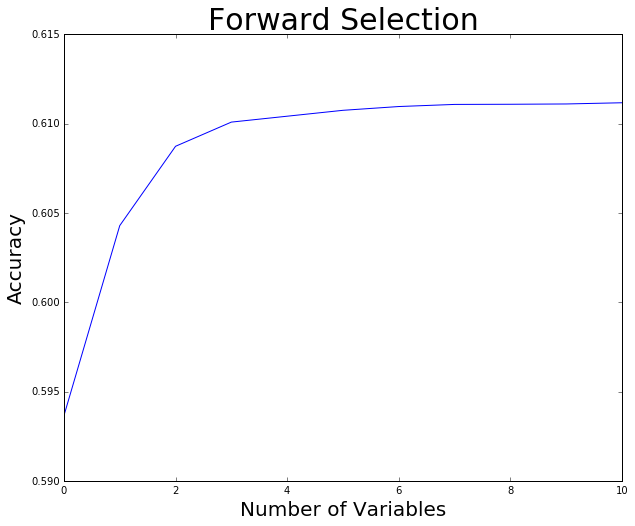

In [1466]:
plt.figure(figsize=(10,8))

plt.plot( range(len(ans[0])), ans[1])
plt.ylabel('Accuracy', fontsize=20)
plt.title('Forward Selection', fontsize=30)
plt.xlabel('Number of Variables', fontsize=20)

plt.show()

In [1445]:
temp_train = pd.concat([df[ans[0]+['player_game_ID']+['SHOT_NUMBER']], y.reset_index()], axis=1)
min_range = range(max(raw_train['SHOT_NUMBER'])+1)
acc_min = np.zeros((max(raw_train['SHOT_NUMBER'])+1))

for i in min_range:
    temp = sort_by_attempts(i, temp_train)
    ytemp = temp['FGM']
    xtemp = temp[ans[0]]
    log = LogisticRegression()
    log.fit( xtemp, ytemp )
    acc_min[i] = log.score( xtemp, ytemp )
    
max_range = range(1,(max(raw_train['SHOT_NUMBER'])+1))
acc_max = np.zeros( max(raw_train['SHOT_NUMBER']) )

for i in max_range:
    temp = sort_by_max_attempts(i, temp_train)
    ytemp = temp['FGM']
    xtemp = temp[ans[0]]
    log = LogisticRegression()
    log.fit( xtemp, ytemp )
    acc_max[i-1] = log.score( xtemp, ytemp )
    

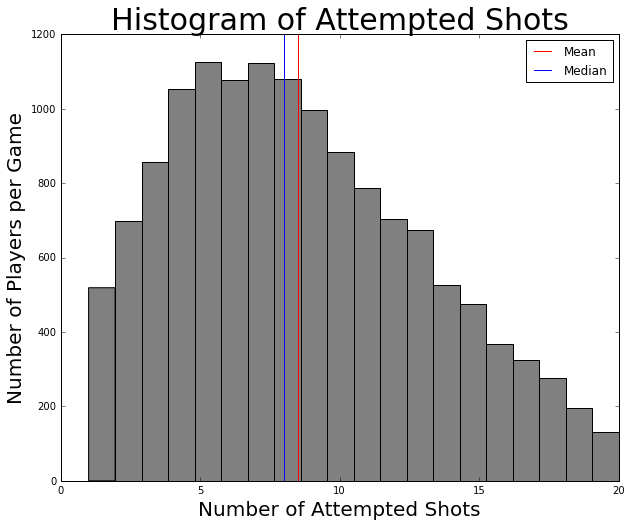

In [1467]:
plt.figure(figsize=(10,8))
plt.hist(np.unique( raw['player_game_ID'], return_counts = True )[1], bins=20,color='gray')

plt.axvline(x = np.mean(np.unique( raw['player_game_ID'], return_counts = True )[1]), color='r')
plt.axvline(x = np.median(np.unique( raw['player_game_ID'], return_counts = True )[1]), color='b')
plt.legend(('Mean','Median'))

plt.ylabel('Number of Players per Game', fontsize=20)
plt.xlabel('Number of Attempted Shots', fontsize=20)

plt.title('Histogram of Attempted Shots', fontsize=30)

plt.show()

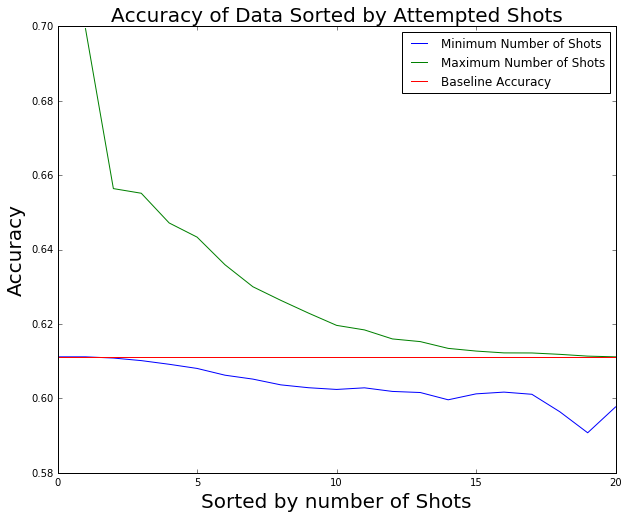

In [1469]:
plt.figure(figsize=(10,8))

plt.plot(min_range, acc_min)
plt.plot(max_range, acc_max)
plt.axhline(ans[1][-1], color='r')
plt.legend(('Minimum Number of Shots','Maximum Number of Shots','Baseline Accuracy'))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Sorted by number of Shots', fontsize=20)
plt.title('Accuracy of Data Sorted by Attempted Shots', fontsize=20)

plt.show()

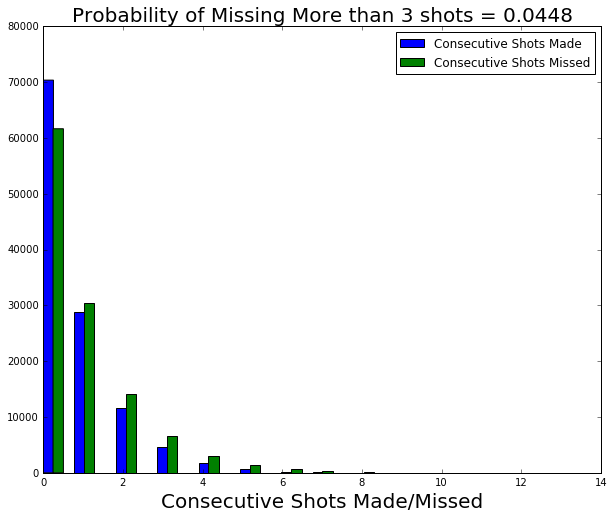

In [1470]:
plt.figure(figsize=(10,8))

plt.hist( hot_hand['con_shot'], bins=50 )
plt.hist( hot_hand['con_miss']+0.25, bins=50 )
plt.legend(('Consecutive Shots Made','Consecutive Shots Missed'))
plt.xlabel('Consecutive Shots Made/Missed', fontsize=20)

plt.title('Probability of Missing More than 3 shots = ' + str(np.round(np.mean(hot_hand['con_miss']>3),4)), fontsize=20)

plt.show()

In [198]:
def LogReg_analysis(X_data,Y_data,subsample_size,C_values,repeats):
    
    intercepts = np.zeros([repeats,len(C_values)])
    coeffs = np.zeros([repeats,len(C_values),len(X_data.columns)])
    acc = np.zeros([repeats,len(C_values)])
    for i in range(repeats):
        x_data,OOB_x,y_data,OOB_y = train_test_split(X_data,Y_data,train_size = subsample_size)
        for k in range(len(C_values)):
            LR_mod = LogisticRegression(C=C_values[k])
            LR_mod.fit(x_data,y_data)
            acc[i,k] = LR_mod.score(OOB_x,OOB_y)
            coeffs[i,k,:] = LR_mod.coef_
            intercepts[i,k] = LR_mod.intercept_
    comb_coeffs = np.zeros([repeats,len(C_values),len(X_data.columns)+1])   
    comb_coeffs[:,:,:-1] = coeffs
    comb_coeffs[:,:,-1] = intercepts
    
    acc_data = acc
    coeff_data = comb_coeffs
    coeff_names = list(X_data.columns) + ['intercept']
    reg_param_values = C_values
    #
    box = acc_data[:,np.argmax(acc.mean, axis=0)]
    #
    fig = plt.figure(figsize = (10,8))
    ax2 = fig.add_subplot(111)
    ax2.errorbar(range(coeff_data.shape[2]), coeff_data[:,-1,:].mean(axis=0),
                 yerr=coeff_data[:,-1,:].std(axis=0),
                fmt='o-')
    ax2.grid(True)
    ax2.set_ylabel('Coefficient value',fontsize=20)
    ax2.set_xlabel('Predictor column location (last predictor=intercept)',fontsize=20)
    ax2.set_title('Average variable importance',fontsize=20)
    ax2.set_xticks(range(len(coeff_names)))
    ax2.set_xticklabels(coeff_names,rotation=80,fontsize=15)
    plt.show()
    
    return box

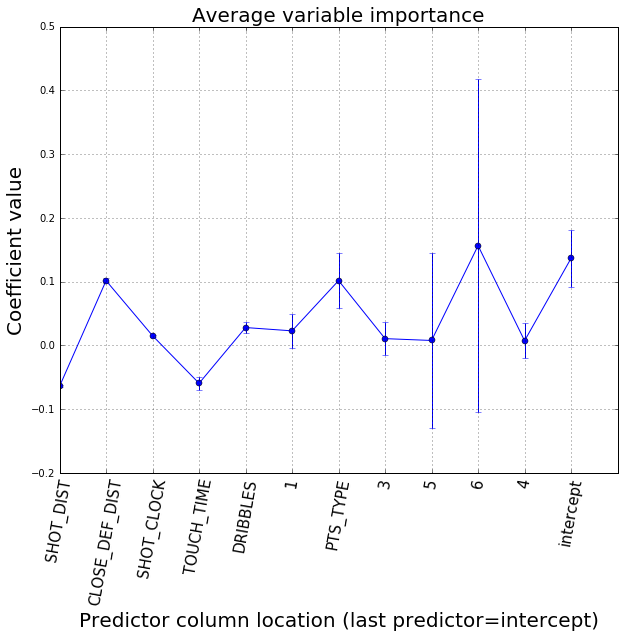

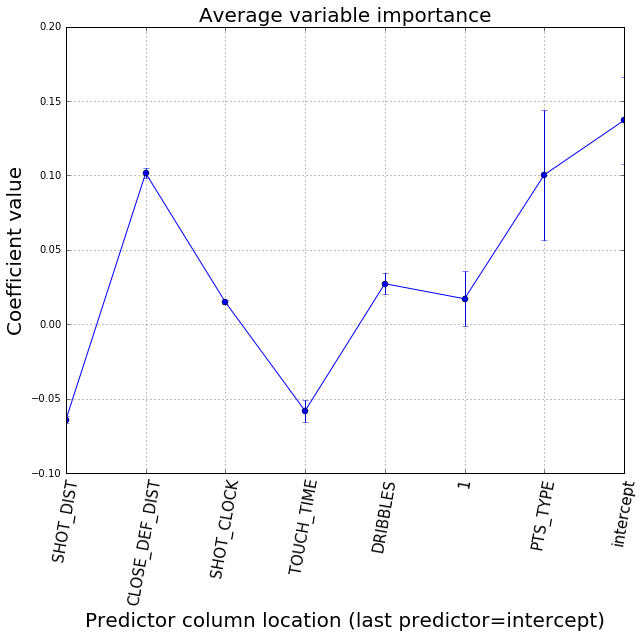

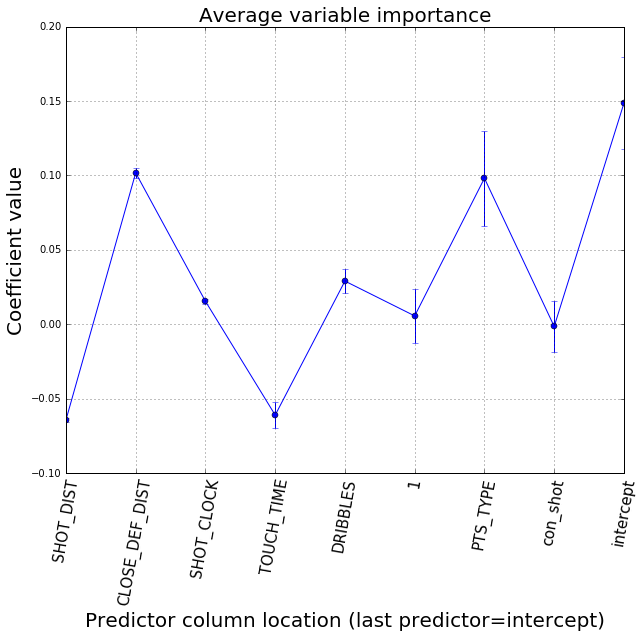

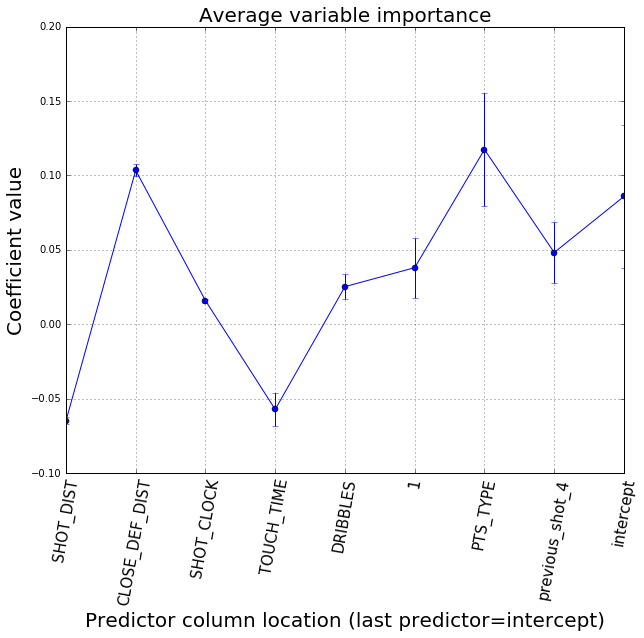

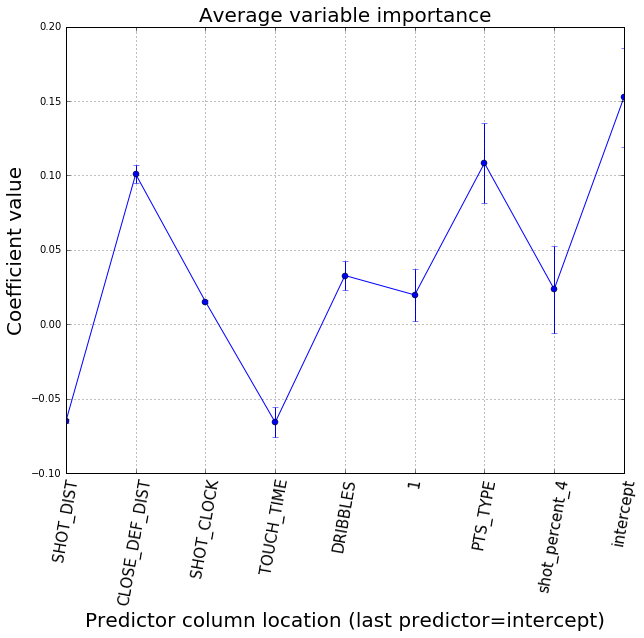

In [199]:
C_values = [0.1,0.5,0.8,1,5,10,20]

box_base = LogReg_analysis(xtrain[ans[0]], ytrain, 0.3, C_values, 15)
box_ref = LogReg_analysis(xtrain[ans[0][0:7]], ytrain, 0.3, C_values, 15)

box = np.empty((3,len(box_ref) ))
z = 0

for hh in hot_hand.columns[1:]:
    box[z] = LogReg_analysis(xtrain[ans[0][0:7]+[hh]], ytrain, 0.3, C_values, 15)
    z = z + 1

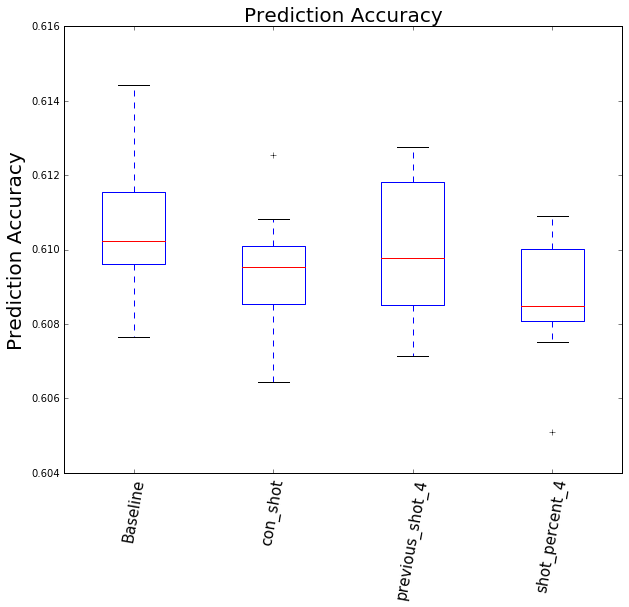

In [224]:
data = [box_ref, box[0], box[1], box[2]]
# multiple box plots on one figure
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_title('Prediction Accuracy', fontsize=20)
ax.set_ylabel('Prediction Accuracy',fontsize=20)
ax.set_xticks( range(1,5) )
ax.set_xticklabels(['Baseline'] + list(hot_hand.columns[1:]),rotation=80,fontsize=15)
plt.show()

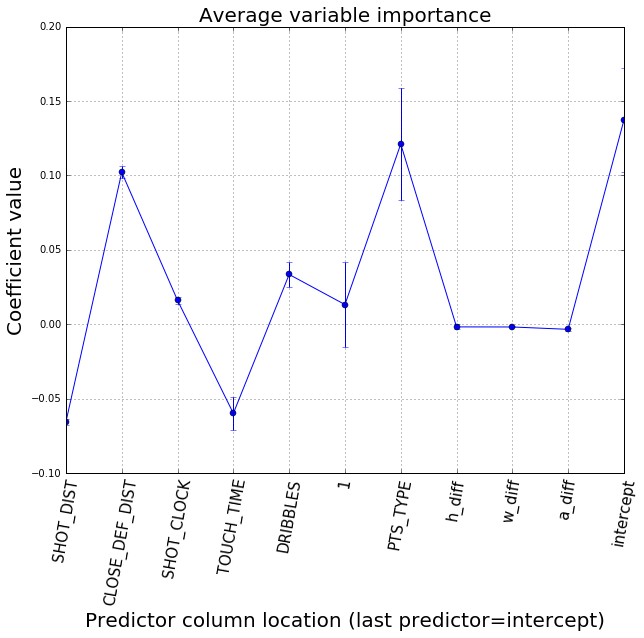

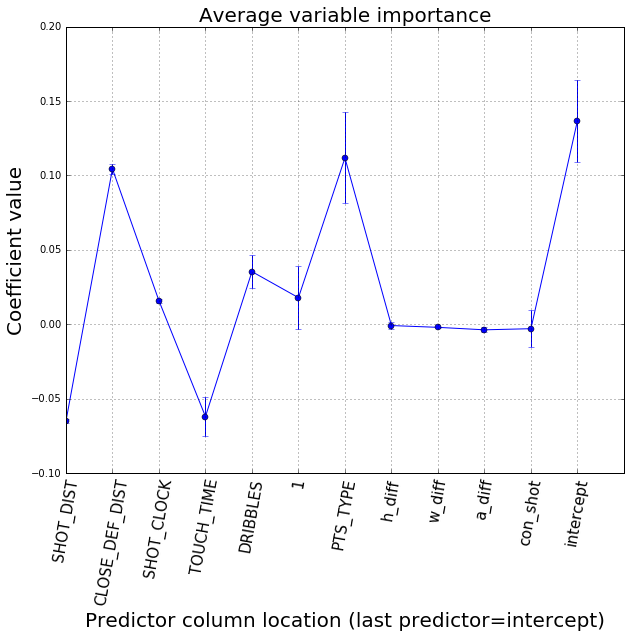

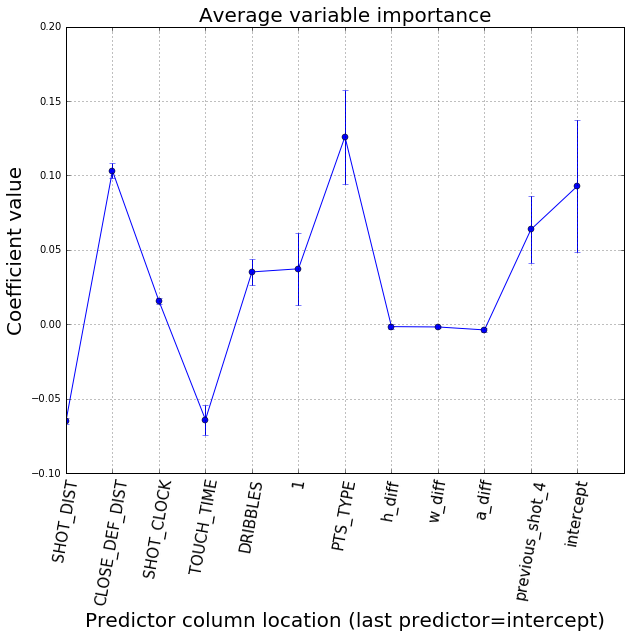

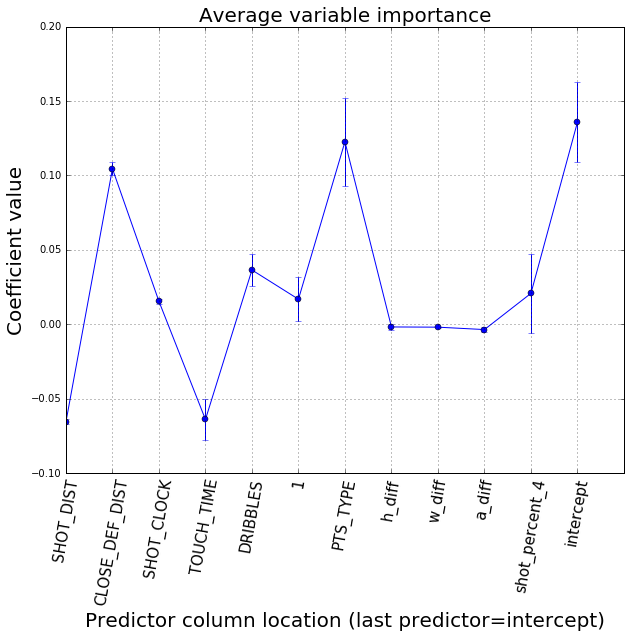

In [203]:
C_values = [0.1,0.5,0.8,1,5,10,20]

box2_ref = LogReg_analysis(xtrain[ans[0][0:7]+list(bio_diff.columns[1:])], ytrain, 0.3, C_values, 15)

box2 = np.empty((3,len(box_ref) ))
z = 0

for hh in hot_hand.columns[1:]:
    box2[z] = LogReg_analysis(xtrain[ans[0][0:7]+list(bio_diff.columns[1:])+[hh]], ytrain, 0.3, C_values, 15)
    z = z + 1

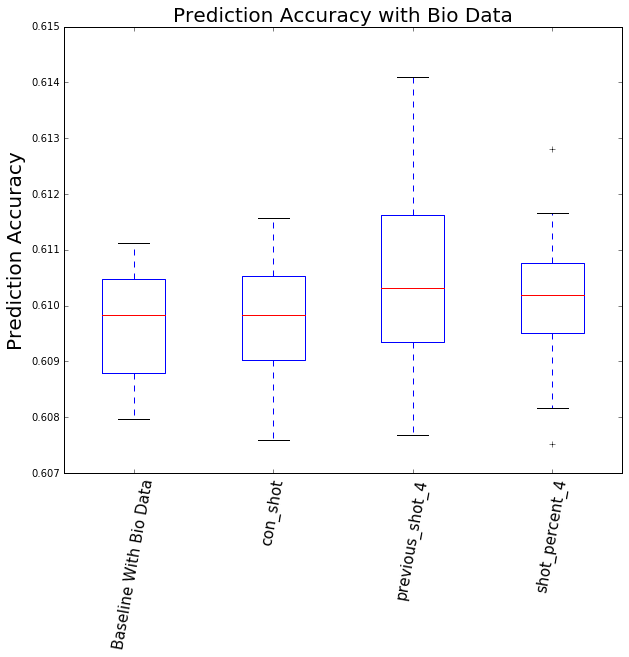

In [223]:
data = [box2_ref, box2[0], box2[1], box2[2]]
# multiple box plots on one figure
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_title('Prediction Accuracy with Bio Data', fontsize=20)
ax.set_ylabel('Prediction Accuracy',fontsize=20)
ax.set_xticks( range(1,5) )
ax.set_xticklabels(['Baseline With Bio Data'] + list(hot_hand.columns[1:]),rotation=80,fontsize=15)
plt.show()

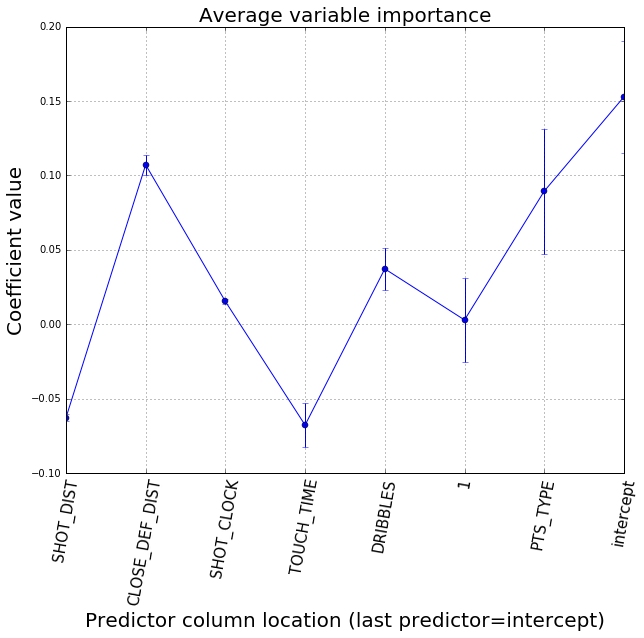

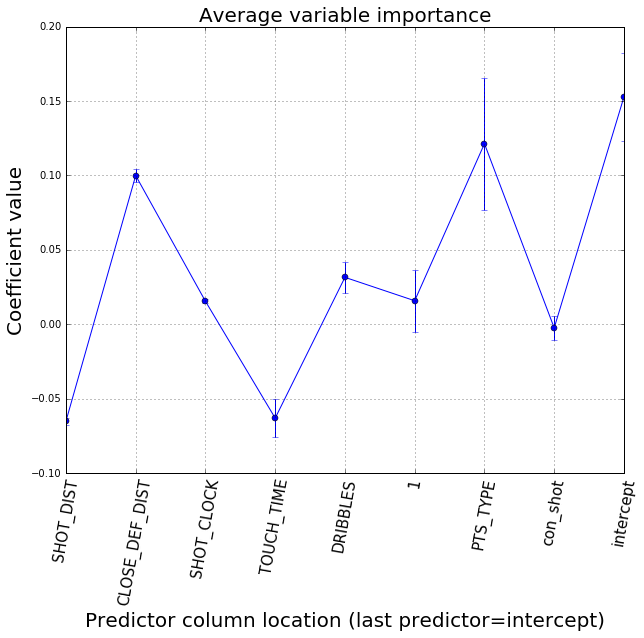

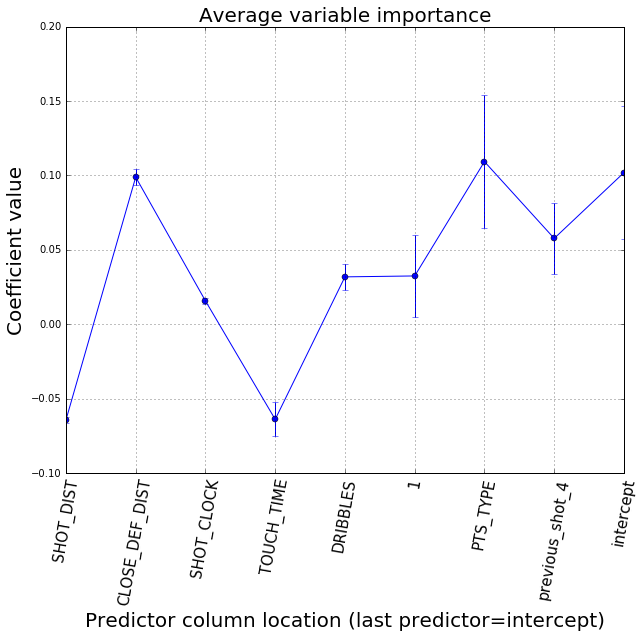

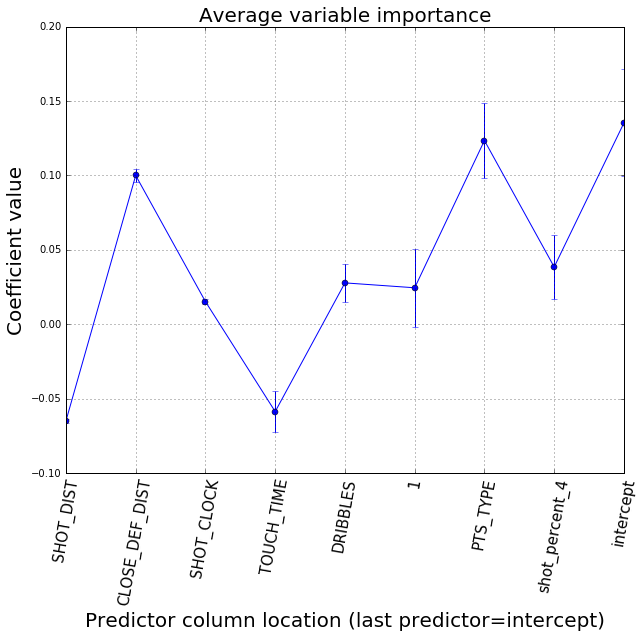

In [217]:
temp = sort_by_attempts(9, pd.concat([xtrain, ytrain],axis=1) )
C_values = [0.1,0.5,0.8,1,5,10,20]

box3_ref = LogReg_analysis(temp[ans[0][0:7]], temp['FGM'], 0.3, C_values, 15)

box3 = np.empty((3,len(box_ref) ))
z = 0

for hh in hot_hand.columns[1:]:
    box3[z] = LogReg_analysis(xtrain[ans[0][0:7]+[hh]], ytrain, 0.3, C_values, 15)
    z = z + 1

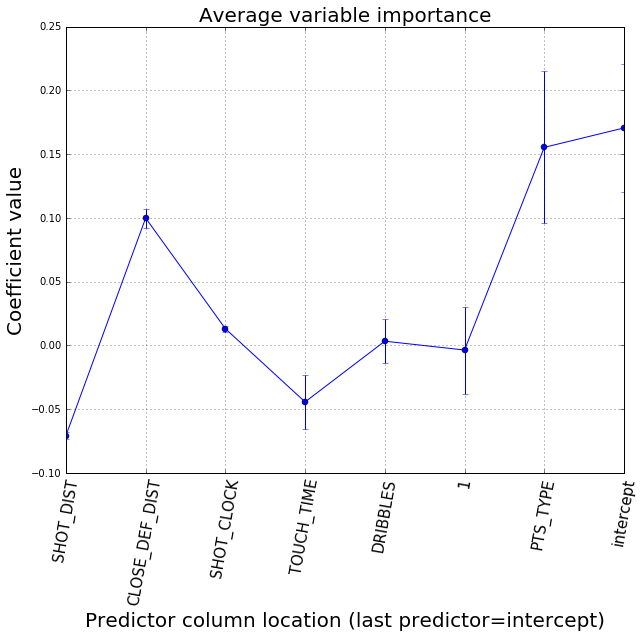

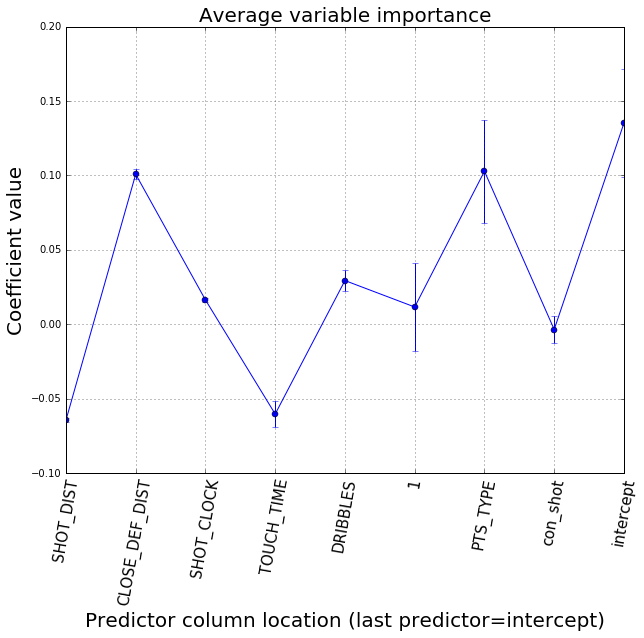

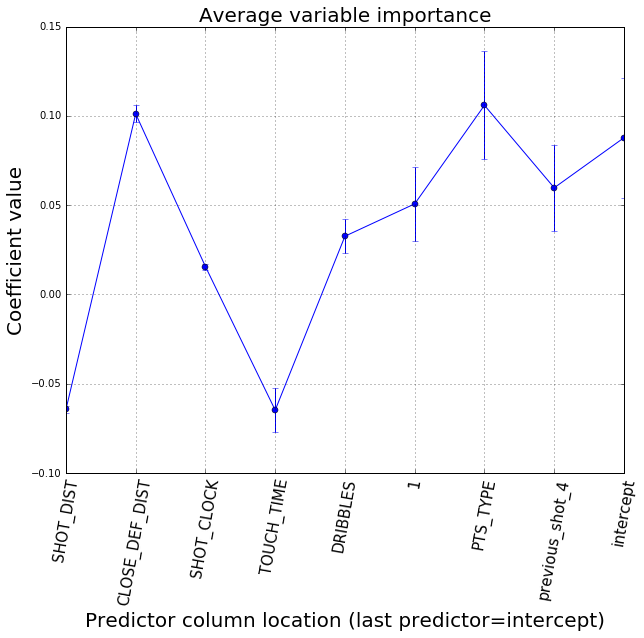

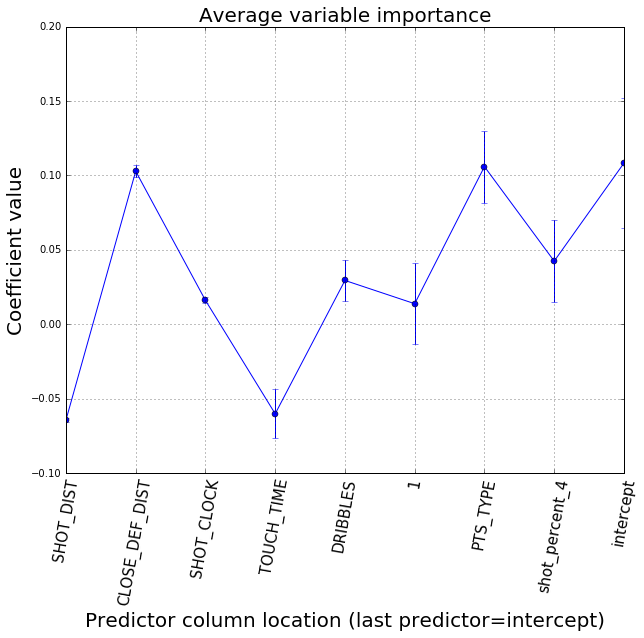

In [218]:
temp = sort_by_max_attempts(9, pd.concat([xtrain, ytrain],axis=1) )
C_values = [0.1,0.5,0.8,1,5,10,20]

box4_ref = LogReg_analysis(temp[ans[0][0:7]], temp['FGM'], 0.3, C_values, 15)

box4 = np.empty((3,len(box_ref) ))
z = 0

for hh in hot_hand.columns[1:]:
    box4[z] = LogReg_analysis(xtrain[ans[0][0:7]+[hh]], ytrain, 0.3, C_values, 15)
    z = z + 1

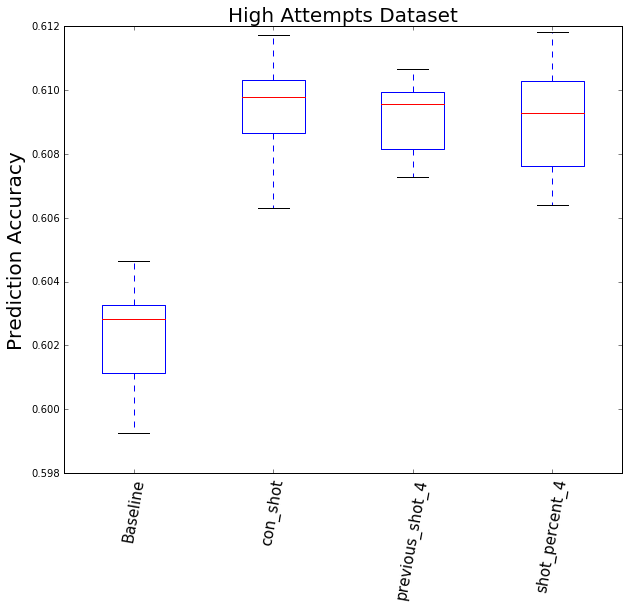

In [221]:
data = [box3_ref, box3[0], box3[1], box3[2]]
# multiple box plots on one figure
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_title('High Attempts Dataset', fontsize=20)
ax.set_ylabel('Prediction Accuracy',fontsize=20)
ax.set_xticks( range(1,5) )
ax.set_xticklabels(['Baseline'] + list(hot_hand.columns[1:]),rotation=80,fontsize=15)
plt.show()

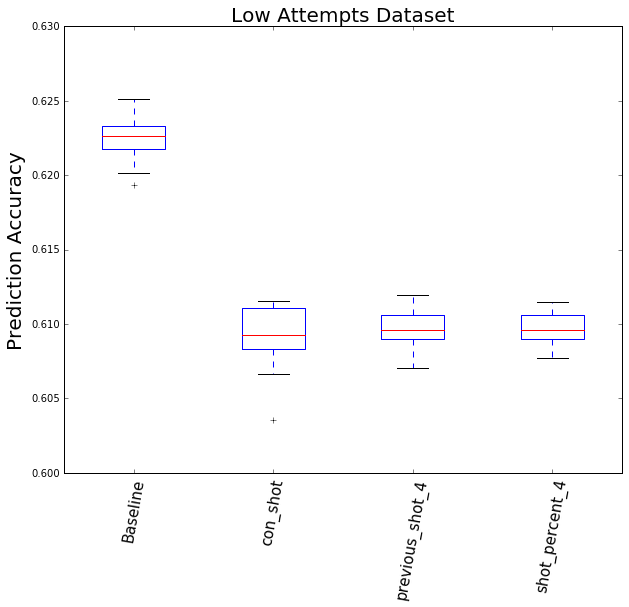

In [222]:
data = [box4_ref, box4[0], box4[1], box4[2]]
# multiple box plots on one figure
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_title('Low Attempts Dataset', fontsize=20)
ax.set_ylabel('Prediction Accuracy',fontsize=20)
ax.set_xticks( range(1,5) )
ax.set_xticklabels(['Baseline'] + list(hot_hand.columns[1:]),rotation=80,fontsize=15)
plt.show()

In [225]:
def LogReg_analysis2(X_data,Y_data,subsample_size,C_values,repeats):
    
    intercepts = np.zeros([repeats,len(C_values)])
    coeffs = np.zeros([repeats,len(C_values),len(X_data.columns)])
    acc = np.zeros([repeats,len(C_values)])
    for i in range(repeats):
        x_data,OOB_x,y_data,OOB_y = train_test_split(X_data,Y_data,train_size = subsample_size)
        for k in range(len(C_values)):
            LR_mod = LogisticRegression(C=C_values[k])
            LR_mod.fit(x_data,y_data)
            acc[i,k] = LR_mod.score(OOB_x,OOB_y)
            coeffs[i,k,:] = LR_mod.coef_
            intercepts[i,k] = LR_mod.intercept_
    comb_coeffs = np.zeros([repeats,len(C_values),len(X_data.columns)+1])   
    comb_coeffs[:,:,:-1] = coeffs
    comb_coeffs[:,:,-1] = intercepts
    
    acc_data = acc
    coeff_data = comb_coeffs
    coeff_names = list(X_data.columns) + ['intercept']
    reg_param_values = C_values
    #
    CC = C_values[np.argmax(acc.mean, axis=0)]
    
    return CC

In [233]:
CC = list()

c = LogReg_analysis2(xtrain[ans[0][0:7]], ytrain, 0.3, C_values, 15)
CC.append(c)
c = LogReg_analysis2(xtrain[ans[0][0:7]+list(bio_diff.columns[1:])], ytrain, 0.3, C_values, 15)
CC.append(c)
c = LogReg_analysis2(xtrain[ans[0][0:7]+list(bio_diff.columns[1:])+[hot_hand.columns[2]]], ytrain, 0.3, C_values, 15)
CC.append(c)
temp1 = sort_by_max_attempts(9, pd.concat([xtrain, ytrain],axis=1) )
c = LogReg_analysis2(temp1[ans[0][0:7]], temp1['FGM'], 0.3, C_values, 15)
CC.append(c)
temp2 = sort_by_attempts(9, pd.concat([xtrain, ytrain],axis=1) )
c = LogReg_analysis2(temp2[ans[0][0:7]+[hot_hand.columns[2]]], temp2['FGM'], 0.3, C_values, 15)
CC.append(c)

In [240]:
acc=list()

log = LogisticRegression(C=0.1)

log.fit(xtrain[ans[0][0:7]], ytrain)
acc.append(log.score(xtest[ans[0][0:7]], ytest))

log.fit(xtrain[ans[0][0:7]+list(bio_diff.columns[1:])], ytrain)
acc.append( log.score(xtest[ans[0][0:7]+list(bio_diff.columns[1:])], ytest) )

log.fit(xtrain[ans[0][0:7]+list(bio_diff.columns[1:])+[hot_hand.columns[2]]], ytrain)
acc.append( log.score(xtest[ans[0][0:7]+list(bio_diff.columns[1:])+[hot_hand.columns[2]]], ytest) )

#

temp1 = sort_by_max_attempts(9, pd.concat([xtrain, ytrain],axis=1) )
temp2 = sort_by_max_attempts(9, pd.concat([xtest, ytest],axis=1) )

log.fit(temp1[ans[0][0:7]], temp1['FGM'])
acc.append( log.score(temp2[ans[0][0:7]], temp2['FGM']) )

temp3 = sort_by_attempts(9, pd.concat([xtrain, ytrain],axis=1) )
temp4 = sort_by_attempts(9, pd.concat([xtest, ytest],axis=1) )

log.fit(temp3[ans[0][0:7]+[hot_hand.columns[2]]], temp3['FGM'])
acc.append( log.score(temp4[ans[0][0:7]+[hot_hand.columns[2]]], temp4['FGM']) )

In [241]:
acc

[0.61503956667089843,
 0.61288138462189501,
 0.61389699970377898,
 0.61982378854625553,
 0.60981955518254305]